In [1]:
# I would like to study the climatology of wind speed and directions
# drawing histograms or hodographs

# Further, this could be linked to precipitation

In [1]:
%load_ext autoreload
%autoreload 2

In [17]:
import numpy as np
import pandas as pd
import glob
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats

import sys; sys.path.insert(1, '/home/alessandro/thesis_material')
import os

import geometry as gm
#import conversion as cnv
from func_statistics import *
#from coare_functions import *

import meteo                    # wind_dir_speed
import metpy.calc as mpcalc
from metpy.units import units
import lcl

from windrose import WindroseAxes
import cartopy.crs as ccrs
crs = ccrs.PlateCarree()
#from plotmap import plot_background

from plotdistr import * #fb_distribution_npoint, perc_distribution, scatterplot_fit, hist2d, perc_distribution_pvalue
from pdist_fb_distrib_save_fast import *

import warnings; warnings.filterwarnings("ignore")

In [3]:
# find data
path = '/saturn/simu_Caribbean/coupled_2km/output/'
files_ls = ['QCLOUD', 'U', 'V', 'W', 'OLR', 'PH', 'PHB', 'QVAPOR', 'PB', 'P', 'T']
files_ls = [name + '.nc' for name in files_ls]
wrf_files = [path+name for name in files_ls]
#fname_list = sorted(glob.glob(wrf_files + '*'))

In [4]:
# import sea_mask
if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_new.npy'):
    sea_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_new.npy')
    
if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_noWarmPatch_noWest.npy'):
    sea_mask_modified = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_noWarmPatch_noWest.npy')
    sea_mask_modified_nan = np.ones_like(sea_mask_modified)
    sea_mask_modified_nan[sea_mask_modified==0] = np.nan

In [20]:
# MATTE AVEVA GIA' CALCOLATO TUTTE LE CORRELAZIONI 
# E HA STIMATO QUESTA LUNGHEZZA?
L = 30
nskip = int(L/2)
nt = int(1)

# from top pbl upwards
# SOPRA PBL LA LUNGEHZZA DI CORRELAZIONE AUMENTA?
# NEL SENSO CHE I SEGNALI HANNO PIù SPAZIO PER PROPAGARSI?
Ltop = 150
nskiptop = int(Ltop/2)
nttop = int(1)

# reference population mean
popmean = 0.


In [6]:
# load U component
U_day = xr.open_dataset(wrf_files[files_ls.index('U.nc')])
U_day = U_day['U'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-03-01T01:30:00.000000000')).groupby('time_counter.day').mean()

i = np.arange(0, sea_mask.shape[1])
U_day = 0.5*(U_day[:,:,:,i] + U_day[:,:,:,i+1])

In [7]:
# select data oversea
U_day = U_day.where(sea_mask_modified, drop=False)

In [8]:
# load U component
V_day = xr.open_dataset(wrf_files[files_ls.index('V.nc')])
V_day = V_day['V'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-03-01T01:30:00.000000000')).groupby('time_counter.day').mean()

j = np.arange(0, sea_mask.shape[0])
V_day = 0.5*(V_day[:,:,j,:] + V_day[:,:,j+1,:])

In [9]:
# select data oversea
V_day = V_day.where(sea_mask_modified, drop=False)

In [10]:
# retrieve wind quantities
wind_dir, wind_speed = np.zeros_like(V_day), np.zeros_like(V_day)

In [11]:
lev = V_day.lev_M.values.astype(int)-1
wind_dir, wind_speed, wind_dir_flat_nan, wind_speed_flat_nan = meteo.wind_dir_speed(U_day[:,lev,:,:], V_day[:,lev,:,:], interp=False, mask=None, flat_nan=True)

In [12]:
dir_flat_nan = wind_dir[:,0:15,:,:]
dir_flat_nan = dir_flat_nan[~np.isnan(dir_flat_nan)].flatten()

ws_flat_nan = wind_speed[:,0:15,:,:]
ws_flat_nan = ws_flat_nan[~np.isnan(ws_flat_nan)].flatten()

Text(0.5, 1.0, 'FEB frequency (%) of wind direction and intensity [m/s], SFC-800 hPa')

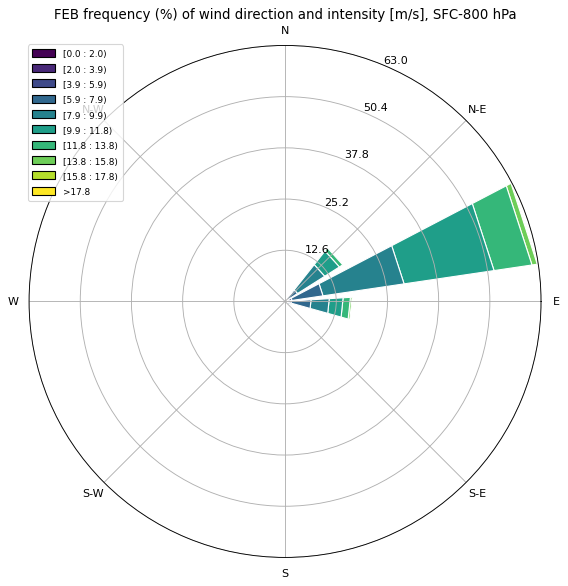

In [13]:
ax = WindroseAxes.from_ax()
ax.bar(dir_flat_nan, ws_flat_nan, normed=True, opening=0.8, edgecolor='white', bins=10, nsector=15) 
ax.set_legend(loc='upper left')
ax.set_title('FEB frequency (%) of wind direction and intensity [m/s], SFC-800 hPa')

#plt.savefig('/venus/tesi_ale/img_EU/WIND/daily/FEB/windrose_lowtropo_feb.png')

In [15]:
with open('/venus/tesi_ale/data_EU/SST/daily/FEB/dSST_day_feb.npy', 'rb') as f:
    dsst_day = np.load(f)
    f.close()

dsst_day = dsst_day*sea_mask_modified_nan

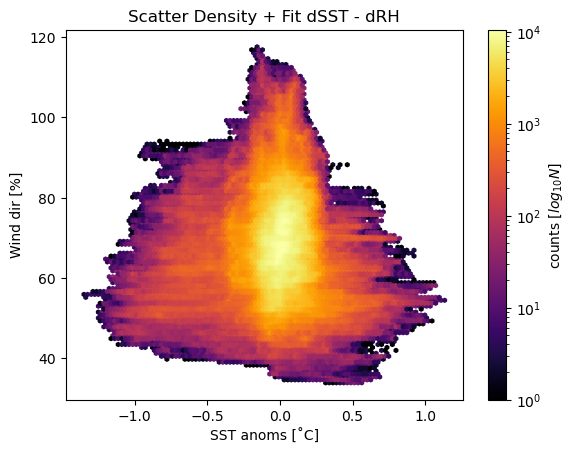

In [24]:
dsst = True

if not dsst:
    x =  (sst_day-273.15)
    y =  wind_dir
    fit, corcoe, p_value, p_value_cannelli, sigmas_full = slopes_r_p_mix(x, y, nt, nskip)
    title=' Scatter Density + Fit SST - RH'
    xlabel='SST [˚C]'
    ylabel='RH [%]'
    
else:
    x = dsst_day
    y = wind_dir[:,0,:,:]       
    
    fit, corcoe, p_value, p_value_cannelli, sigmas_anoms = slopes_r_p_mix(x, y, nt, nskip)
    title='Scatter Density + Fit dSST - dRH'
    xlabel='SST anoms [˚C]'
    ylabel='Wind dir [%]'
    '''miny = -150 ; maxy = 100
    minx = -2 ; maxx = 1'''
    
pos = [0.1,0.9]
fig = density_hexbin(x,y,fit=None,corcoe=None,grdsz=100,title=title,xlabel=xlabel,ylabel=ylabel, colormap='inferno', pos=pos)


In [ ]:
#####  RETRIEVE PRESSURE

In [15]:
pres_base = xr.open_dataset(wrf_files[files_ls.index('PB.nc')])
pres_base = pres_base['PB']

pres = xr.open_dataset(wrf_files[files_ls.index('P.nc')])
pres = pres['P'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-03-01T01:30:00.000000000'))


In [16]:
pres = (pres+pres_base)/100.                # hectoPascals
pres = pres.where(sea_mask, drop=False)

del pres_base

In [17]:
# mean base pressure over domain
mean_vert_pres = np.nanmean(pres, axis=(0,2,3))

In [35]:
### LOAD PRESSURE COLUMN
mean_vert_pres = np.load('/venus/tesi_ale/data_EU/PRES/daily/FEB/mean_vert_pres.npy')

In [ ]:
###### RETRIEVE DAILY DATA

In [26]:
wrf_hourly = path + 'Caraibes_WRF_3h_surf.nc'
ds_hourly = xr.open_dataset(wrf_hourly)
ds_hourly = ds_hourly.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-03-01T01:30:00.000000000'))


In [28]:
# daily varaibles
# select sst,  PBLH

sst_day = ds_hourly['SST'].groupby('time_counter.day').mean()            
sst_day = sst_day.where(sea_mask_modified, drop=False).values;                              

PBLH_day = ds_hourly['PBLH'].groupby('time_counter.day').mean()
PBLH_day = PBLH_day.where(sea_mask_modified, drop=False).values;             


In [27]:
# compute anomalies wind data
s = 100

dwind_speed = np.zeros(wind_speed.shape)

for t in range(0,wind_speed.shape[0]):
    if t % 10 == 0:
        print(t)
    
    for h in range(0,wind_speed.shape[1]):
        ws_ave = gm.nan_gaussian_filter(wind_speed[t,h],s)                            
        dwind_speed[t,h] = wind_speed[t,h] - ws_ave

0
10
20


In [28]:
# save anomalies ni windspeed
my_save_data('/venus/tesi_ale/data_EU/WIND/daily/FEB/dwind_speed_day_feb.npy', [dwind_speed])

In [25]:
# LOAD dWS
dwind_speed = np.load('/venus/tesi_ale/data_EU/WIND/daily/FEB/dwind_speed_day_feb.npy')
dwind_speed = dwind_speed*sea_mask_modified_nan

In [29]:
# PBLH IN PRESSURE VALUES! 
# output is in hPa
PBLH_pres = mpcalc.height_to_pressure_std(PBLH_day*units.meters)
PBLH_pres = PBLH_pres.magnitude #.m_as('hPa')

In [30]:
# MATTE AVEVA GIA' CALCOLATO TUTTE LE CORRELAZIONI 
# E HA STIMATO QUESTA LUNGHEZZA?
L = 30
nskip = int(L/2)
nt = int(1)

# from top pbl upwards
# SOPRA PBL LA LUNGEHZZA DI CORRELAZIONE AUMENTA?
# NEL SENSO CHE I SEGNALI HANNO PIù SPAZIO PER PROPAGARSI?
Ltop = 150
nskiptop = int(Ltop/2)
nttop = int(1)

# reference population mean
popmean = 0.

perc_step = 5
nbins = int(100/perc_step) # Number of bins.

In [31]:
# DISTRIBUTION PBLH vs SST bin - DAILY 
perc_step = 5
nbins = int(100/perc_step) # Number of bins.

#  PBLH distrib

# perc
pdist_sst, pdist_PBLH, pstd_PBLH, pstderr_PBLH, pnpoints_PBLH, ppvalue_PBLH = \
distrib_2d(sst_day, PBLH_pres, perc_step, nbins, popmean, perc_fixbin = 'perc')



In [32]:
# DISTRIBUTION PBLH vs dSST bin - DAILY 
perc_step = 5
nbins = int(100/perc_step) # Number of bins.

#  PBLH distrib

# perc
pdist_dsst, pdist_PBLH_dsst, pstd_PBLH_dsst, pstderr_PBLH_dsst, pnpoints_PBLH_dsst, ppvalue_PBLH_dsst = \
distrib_2d(dsst_day, PBLH_pres, perc_step, nbins, popmean, perc_fixbin = 'perc')



In [41]:
# MATTE AVEVA GIA' CALCOLATO TUTTE LE CORRELAZIONI 
# E HA STIMATO QUESTA LUNGHEZZA?
L = 30
nskip = int(L/2)
nt = int(1)

# from top pbl upwards
# SOPRA PBL LA LUNGEHZZA DI CORRELAZIONE AUMENTA?
# NEL SENSO CHE I SEGNALI HANNO PIù SPAZIO PER PROPAGARSI?
Ltop = 150
nskiptop = int(Ltop/2)
nttop = int(1)

# reference population mean
popmean = 0.

In [33]:
# DISTRIBUTION WS vs SST - DAILY + PVALUE SUBSAMPLED height dependent
perc_step = 5
nbins = int(100/perc_step) # Number of bins.

pdist_sst, pdist_ws, pstd_ws, pstderr_ws, pnpoints_ws, ppvalue_ws_sub = \
dist_3d_subsample(sst_day, wind_speed, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=14, perc_fixbin='perc')


0
10
20
30


/venus/tesi_ale/img_EU/WIND/daily/FEB/NEW_pdist_sst_ws_lowtropo.png


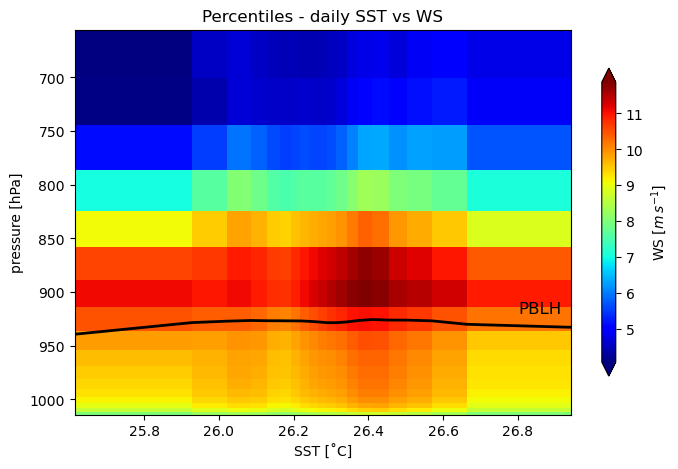

In [39]:
# plot

p_level_plot = int(18)

perc = True
title = 'Percentiles' if perc else 'Fixed bins'
x = pdist_sst if perc else dist_sst
var = pdist_ws if perc else dist_ws
minval = 0. ; maxval = -minval

fig, ax1 = plt.subplots(figsize=(8, 5))  
ax1.invert_yaxis()
p1 = ax1.pcolormesh(x-273.15, mean_vert_pres[0:p_level_plot], var[0:p_level_plot], cmap='jet')
ax1.set_xlabel('SST [˚C]'); ax1.set_ylabel('pressure [hPa]')
plt.title(f'{title} - daily SST vs WS')
cbar = plt.colorbar(p1,ax=ax1, location='right', shrink=0.8, extend='both')  
cbar.set_label(r'WS [$m\,s^{-1}$]')

var_pbl = pdist_PBLH if perc else dist_PBLH
ax1.plot(x-273.15, var_pbl, '-k', linewidth=2)
ax1.text(26.8, 920, 'PBLH', fontsize=12, color='k')



# savefig
path_img = '/venus/tesi_ale/img_EU/WIND/daily/FEB/' #if perc else '/venus/tesi_ale/img_EU/WIND/daily/bins/FEB/'
filename = path_img + 'NEW_pdist_sst_ws_lowtropo.png' #if perc else path_img + 'bins_sst_ws_lowtropo.png'
# plt.savefig(filename)
print(filename)
del filename

In [59]:
# DISTRIBUTION WS vs dSST - DAILY + PVALUE SUBSAMPLED height dependent
perc_step = 5
nbins = int(100/perc_step) # Number of bins.

pdist_dsst, pdist_ws_dsst, pstd_ws_dsst, pstderr_ws_dsst, pnpoints_ws_dsst, ppvalue_ws_dsst_sub = \
dist_3d_subsample(dsst_day, wind_speed, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=14, perc_fixbin='perc')


0
10
20
30


"# fixed bins dQVAPOR vs dSST\ndist_dsst, dist_ws_dsst, std_ws_dsst, stderr_ws_dsst, npoints_ws_dsst, pvalue_ws_dsst_sub = dist_3d_subsample(dsst_day, wind_speed, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=14, perc_fixbin='fb')"

/venus/tesi_ale/img_EU/WIND/daily/FEB/pdist_dsst_ws_lowtropo.png


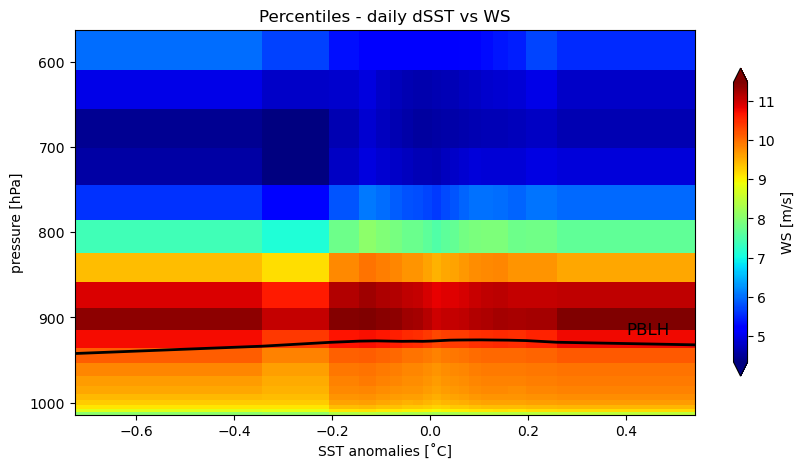

In [72]:
# plot

p_level_plot = int(20)

perc = True
title = 'Percentiles' if perc else 'Fixed bins'
x = pdist_dsst if perc else dist_dsst
var = pdist_ws_dsst if perc else dist_ws_dsst
minval = 0. ; maxval = -minval

fig, ax1 = plt.subplots(figsize=(10, 5))  
ax1.invert_yaxis()
p1 = ax1.pcolormesh(x, mean_vert_pres[0:p_level_plot], var[0:p_level_plot], cmap='jet')
ax1.set_xlabel('SST anomalies [˚C]'); ax1.set_ylabel('pressure [hPa]')
plt.title(f'{title} - daily dSST vs WS')
cbar = plt.colorbar(p1,ax=ax1, location='right', shrink=0.8, extend='both')  
cbar.set_label('WS [m/s]')

var_pbl = pdist_PBLH_dsst if perc else dist_PBLH_dsst
ax1.plot(x, var_pbl, '-k', linewidth=2)
ax1.text(0.4, 920, 'PBLH', fontsize=12, color='k')



# savefig
path_img = '/venus/tesi_ale/img_EU/WIND/daily/FEB/' #if perc else '/venus/tesi_ale/img_EU/WIND/daily/bins/FEB/'
filename = path_img + 'pdist_dsst_ws_lowtropo.png' #if perc else path_img + 'bins_dsst_ws_lowtropo_hatch.png'
#plt.savefig(filename)
print(filename)
del filename

In [41]:
# DISTRIBUTION dWS vs dSST - DAILY + PVALUE SUBSAMPLED height dependent
perc_step = 5
nbins = int(100/perc_step) # Number of bins.

pdist_dsst, pdist_dws, pstd_dws, pstderr_dws, pnpoints_dws, ppvalue_dws_sub = \
dist_3d_subsample(dsst_day, dwind_speed, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=14, perc_fixbin='perc')


0
10
20
30


In [50]:
# DISTRIBUTION PBLH vs dSST bin - DAILY 
perc_step = 2
nbins = int(100/perc_step) # Number of bins.

#  PBLH distrib

# perc
pdist_dsst_2pc, pdist_PBLH_dsst_2pc, pstd_PBLH_dsst_2pc, pstderr_PBLH_dsst_2pc, pnpoints_PBLH_dsst_2pc, ppvalue_PBLH_dsst_2pc = \
distrib_2d(dsst_day, PBLH_pres, perc_step, nbins, popmean, perc_fixbin = 'perc')

/venus/tesi_ale/img_EU/WIND/daily/FEB/NEW_pdist_dsst_dws_lowtropo_hatch.png


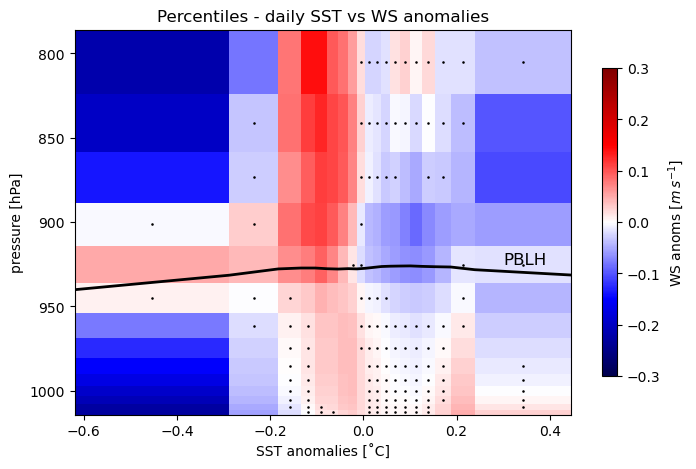

In [47]:
# plot

p_level_plot = int(15)

perc = True
title = 'Percentiles' #if perc else 'Fixed bins'
x = pdist_dsst #if perc else dist_dsst
var = pdist_dws #if perc else dist_dws
minval = -0.3 #if perc else -2. ; 
maxval = -minval

fig, ax1 = plt.subplots(figsize=(8, 5))  
ax1.invert_yaxis()
p1 = ax1.pcolormesh(x, mean_vert_pres[0:p_level_plot], var[0:p_level_plot], vmin=minval, vmax=maxval, cmap='seismic')
ax1.set_xlabel('SST anomalies [˚C]'); ax1.set_ylabel('pressure [hPa]')
plt.title(f'{title} - daily SST vs WS anomalies')
cbar = plt.colorbar(p1,ax=ax1, location='right', shrink=0.8)   #, extend='both')  
cbar.set_label('WS anoms [$m\,s^{-1}$]')

var_pbl = pdist_PBLH_dsst #if perc else dist_PBLH_dsst
ax1.plot(x, var_pbl, '-k', linewidth=2)
ax1.text(0.3, 925, 'PBLH', fontsize=12, color='k')




# DEF punti significativi (pvalue < 0.05)
pval = ppvalue_dws_sub[0:p_level_plot] #if perc else pvalue_dws_sub[0:p_level_plot]
GPbin = mean_vert_pres[1:p_level_plot] - np.diff(mean_vert_pres[0:p_level_plot])*0.5
signif_Lcorr_H = np.zeros((len(mean_vert_pres[0:p_level_plot])-1,len(x)-1))
dsstbin = np.zeros((len(mean_vert_pres[0:p_level_plot])-1,len(x)-1))
for h in range(0,len(mean_vert_pres[0:p_level_plot])-1):
    cond1 = pval[h,:-1] > 0.05
    #cond2 = np.abs(var[h,:-1]) < 0.1*np.nanmean(np.abs(var))
    cond = (cond1) # | (cond2)
#     cond = cond1
    signif_Lcorr_H[h,:] = np.zeros(len(x)-1) + np.nan
    signif_Lcorr_H[h, cond] = GPbin[h]
    dsstbin[h,:] = x[1:] - np.diff(x)*0.5
    
plt.scatter(dsstbin,signif_Lcorr_H,  s=0.7, color='k')



# savefig
path_img = '/venus/tesi_ale/img_EU/WIND/daily/FEB/' ##if perc else '/venus/tesi_ale/img_EU/WIND/daily/bins/FEB/'
filename = path_img + 'NEW_pdist_dsst_dws_lowtropo_hatch.png' ##if perc else path_img + 'bins_dsst_dws_lowtropo_hatch.png'
# plt.savefig(filename)
print(filename)
del filename

In [ ]:
#############   COMPUTE ANOMALIES OF WIND DIRECTIONS    ###########

In [11]:
with open('/venus/tesi_ale/data_EU/SST/daily/FEB/dSST_day_feb.npy', 'rb') as f:
    dsst_day = np.load(f)

In [13]:
## LOAD WIND ANOMALIES
with open('/venus/tesi_ale/data_EU/WIND/daily/FEB/dU_day_feb.npy', 'rb') as f:
    dU = np.load(f)
    
with open('/venus/tesi_ale/data_EU/WIND/daily/FEB/dV_day_feb.npy', 'rb') as f:
    dV = np.load(f)

In [11]:
# compute anomalies wind data
s = 100

dU, dV = np.zeros(U_day.shape), np.zeros(V_day.shape)
#dw_dir = np.zeros(wind_dir.shape)    # WRONG (I "GUESS", BUT THESE FUNCTIONALS ARE NOT LINEAR)

for t in range(0,dU.shape[0]):
    if t % 10 == 0:
        print(t)
    
    for h in range(0,dU.shape[1]):
        U_ave, V_ave = gm.nan_gaussian_filter(U_day[t,h],s), gm.nan_gaussian_filter(V_day[t,h],s)                           
        dU[t,h], dV[t,h] = U_day[t,h] - U_ave, V_day[t,h] - V_ave

0
10
20


In [12]:
my_save_data('/venus/tesi_ale/data_EU/WIND/daily/FEB/dU_day_feb.npy', [dU])
my_save_data('/venus/tesi_ale/data_EU/WIND/daily/FEB/dV_day_feb.npy', [dV])

In [18]:
## ANOMALIES IN WIND DIRECTION
dw_dir, anoms_magn= meteo.wind_dir_speed(dU, dV, interp=False, mask=None, flat_nan=False)

In [29]:
dw_dir_plot, anoms_magn_plot = dw_dir[:,5,:,:], anoms_magn[:,5,:,:]
dw_dir_plot, anoms_magn_plot = dw_dir_plot[~np.isnan(dw_dir_plot)], anoms_magn_plot[~np.isnan(anoms_magn_plot)]


Text(0.5, 1.0, 'FEB frequency (%) of wind ANOMALIES direction  and intensity [m/s], SFC-800 hPa')

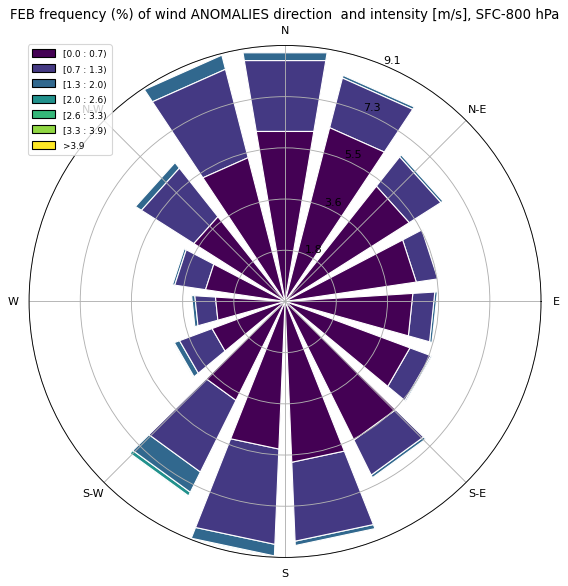

In [32]:
ax = WindroseAxes.from_ax()
ax.bar(dw_dir_plot, anoms_magn_plot, normed=True, opening=0.8, edgecolor='white', bins=7, nsector=15)  # bins=  , nsector=
ax.set_legend(loc='upper left')
ax.set_title('FEB frequency (%) of wind ANOMALIES direction  and intensity [m/s], SFC-800 hPa')

#plt.savefig('/venus/tesi_ale/img_EU/WIND/daily/FEB/windrose_anomalies_lowtropo_feb.png')

In [31]:
# change in direction angle between full flow and small scale flow
delta_dir = wind_dir-dw_dir

In [29]:
'''# build consistent arrays for 3D scattering
dsst_3d = np.repeat(dsst_day[:, np.newaxis, :, :], len(mean_vert_pres), axis=1)    #np.zeros_like(delta_dir)


vert_pres_3d = np.repeat(mean_vert_pres[np.newaxis, :], 29, axis=0)
vert_pres_3d = np.repeat(vert_pres_3d[:, :, np.newaxis], 546, axis=2)
vert_pres_3d = np.repeat(vert_pres_3d[:, :, :, np.newaxis], 573, axis=3)'''

In [33]:
# identify, if any, clusters of data
fig = plt.figure(figsize=(10, 10))

title = 'scatter direction change vs dSST'
ylabel = 'direction change [degrees]'
xlabel = 'dSST [K]'

'''fig = density_hexbin(dsst_day[:,:,:], (delta_dir[:,5,:,:]+360)%360, \
                     fit=None,corcoe=0,grdsz=80,title=title,xlabel=xlabel,ylabel=ylabel, colormap='inferno')'''


'''fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}
ax.hexbin(x, y, gridsize=grdsz, bins='log', cmap=colormap, mincnt=1)
ax.xlabel(xlabel)
ax.ylabel(ylabel)
ax.title(title)
ax.colorbar(label='counts [$log_{10}N$]')'''

#ax = fig.add_subplot(projection='3d')
#     hexbin(x,                    y,             gridsize=grdsz, bins='log',  mincnt=1)

# plt.scatter(delta_dir[10,1,:,:], dsst_day[10,:,:])
# plt.hexbin(delta_dir[10,1,:,:], dsst_day[10,:,:], gridsize=50, bins='log', cmap='Greens',  mincnt=1)

SyntaxError: invalid syntax (2334207404.py, line 13)

In [73]:
perc_step = 5
nbins = int(100/perc_step) # Number of bins.

pdist_dsst, pdist_dw_dir, pstd_dw_dir, pstderr_dw_dir, pnpoints_dw_dir, ppvalue_dw_dir_sub = \
dist_3d_subsample(dsst_day, dw_dir, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=14, perc_fixbin='perc')


0
10
20
30


In [ ]:
####################    COMPUTE COUPLING COEFFICIENT :  U10 - SST   ##################

In [68]:
levss = mean_vert_pres/mean_vert_pres[0]
levss

# I'll choose level 2, let's see what comes out

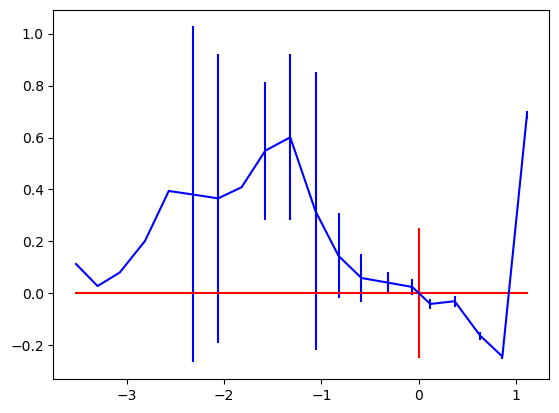

In [87]:
lev = int(9)

plt.errorbar(dist_dsst, dist_dws[lev,:], yerr=stderr_dws[lev,:], xerr=None,\
             label='1015 hPa', ecolor='b', linestyle='-', color='b')
plt.plot(dist_dsst, np.zeros_like(pdist_dsst), '-r')
plt.vlines(0., ymin=-0.25, ymax=0.25, colors='red')

In [13]:
ax = WindroseAxes.from_ax()
ax.bar(wind_dir_flat_nan, wind_speed_flat_nan, normed=True, opening=0.8, edgecolor='white', bins=10, nsector=15)  # bins=  , nsector=
ax.set_legend(loc=0)
ax.set_title('DJF frequency (%) climatology of wind direction and intensity [m/s]')

#plt.savefig('/venus/tesi_ale/img_GS/DJF_windrose.png')
plt.close()